In [118]:
import numpy as np
from dataclasses import dataclass, field
from matplotlib import pyplot as plt
from typing import Callable, List, Optional

In [119]:
# Memory dataclasses
@dataclass
class NeuronForMemory:
    def __init__(
            self,
            param_leak_str:     int,
            param_threshold:    int,
            param_reset:        int,
            state_core:         int
    ):
        self.leak_str   = param_leak_str
        self.threshold  = param_threshold
        self.reset      = param_reset
        self.core       = state_core
    def __repr__(self):
        return f"NeuronForMemory(leak_str={self.leak_str}, threshold={self.threshold}, reset={self.reset}, core={self.core})"

@dataclass
class SynapseForMemory:
    length: int
    word_size: np.dtype

    def __post_init__(self):
        self.weights = np.zeros(self.length, dtype=self.word_size)

    def __getitem__(self, key):
        return self.weights[key]
    
    def __setitem__(self, key, value):
        self.weights[key] = value

    def __len__(self):
        return self.length

    def __repr__(self):
        return f"SynapseForMemory(length={self.length}, weights={self.weights})"


In [120]:
# test dataclasses
print(NeuronForMemory(1, 2, 3, 4))
print(SynapseForMemory(10, np.int8))

NeuronForMemory(leak_str=1, threshold=2, reset=3, core=4)
SynapseForMemory(length=10, weights=[0 0 0 0 0 0 0 0 0 0])


In [121]:
def get_discrete_random_sample(mu: float, sigma: float, min: int, max: int) -> int:
    sample = np.random.normal(loc=mu, scale=sigma)
    return np.clip(
        round(sample),
        min,
        max
    )

def random_neuron() -> NeuronForMemory:
    return NeuronForMemory(
        param_leak_str=get_discrete_random_sample(2**3, 2, 0, 2**5),
        param_threshold=get_discrete_random_sample(2**6, 2**3, 0, 2**11),
        state_core=0,
        param_reset=get_discrete_random_sample(4., 1., 0, 2**3)
    )

In [122]:
@dataclass
class BRAM_Neuron:
    def __init__(
            self,
            length: int,
            randomize_fun: Callable[[], NeuronForMemory] = None
    ):
        self.length = length
        self.neurons = [NeuronForMemory(0, 0, 0, 0) for _ in range(length)]

        if randomize_fun:
            self.__randomize(randomize_fun)

    def __randomize(self, callback):
        for i in range(self.length):
            self.neurons[i] = callback()
        
    def __getitem__(self, key):
        return self.neurons[key]
    
    def __setitem__(self, key, value):
        self.neurons[key] = value

    def __len__(self):
        return len(self.neurons)
    
    def __repr__(self):
        return f"BRAM_Neuron(neurons={self.neurons})"
    

test_bram = BRAM_Neuron(48, random_neuron)
for i in range(48):
    print(test_bram[i])

NeuronForMemory(leak_str=9, threshold=55, reset=3, core=0)
NeuronForMemory(leak_str=7, threshold=73, reset=4, core=0)
NeuronForMemory(leak_str=5, threshold=68, reset=4, core=0)
NeuronForMemory(leak_str=9, threshold=66, reset=3, core=0)
NeuronForMemory(leak_str=6, threshold=63, reset=4, core=0)
NeuronForMemory(leak_str=9, threshold=65, reset=5, core=0)
NeuronForMemory(leak_str=15, threshold=53, reset=2, core=0)
NeuronForMemory(leak_str=10, threshold=77, reset=3, core=0)
NeuronForMemory(leak_str=8, threshold=70, reset=4, core=0)
NeuronForMemory(leak_str=7, threshold=78, reset=5, core=0)
NeuronForMemory(leak_str=6, threshold=61, reset=3, core=0)
NeuronForMemory(leak_str=8, threshold=62, reset=4, core=0)
NeuronForMemory(leak_str=8, threshold=68, reset=3, core=0)
NeuronForMemory(leak_str=7, threshold=82, reset=3, core=0)
NeuronForMemory(leak_str=7, threshold=58, reset=5, core=0)
NeuronForMemory(leak_str=13, threshold=52, reset=5, core=0)
NeuronForMemory(leak_str=7, threshold=71, reset=3, co

In [123]:
def random_synapse(depth: int) -> SynapseForMemory:
    
    temp_synapse = SynapseForMemory(depth, np.int8)
    for i in range(depth):
        temp_synapse[i] = get_discrete_random_sample(0.5, 1., 0, 3)
    return temp_synapse

In [124]:
@dataclass
class BRAM_synaptic_weights:
    def __init__(
            self,
            length: int,
            depth: int,
            word_size: np.dtype,
            randomize_fun: Callable[[int], SynapseForMemory] = None
    ):
        self.length = length
        self.depth = depth
        self.synapses = [SynapseForMemory(length, word_size) for _ in range(length)]

        if randomize_fun:
            self.__randomize(randomize_fun)
        
    def __randomize(self, callback):
        for i in range(self.length):
            self.synapses[i] = callback(self.depth)
    
    def __getitem__(self, key):
        return self.synapses[key]
    
    def __setitem__(self, key, value):
        self.synapses[key] = value

    def __len__(self):
        return (self.length, self.depth)
    
    def __repr__(self):
        return f"BRAM_synaptic_weights(synapses={self.synapses})"
    
test_bram_syn = BRAM_synaptic_weights(48, 48, np.int8, random_synapse)

for i in range(48):
    print(test_bram_syn[i])
        

SynapseForMemory(length=48, weights=[0 0 2 1 0 0 0 1 0 1 1 2 1 1 0 1 2 1 2 1 2 1 0 1 1 2 1 2 2 2 1 1 1 0 1 1 2
 0 1 1 1 1 0 2 1 2 0 1])
SynapseForMemory(length=48, weights=[0 0 3 0 0 0 0 0 1 0 1 0 0 1 1 1 2 0 0 1 1 0 3 0 0 2 0 0 1 0 1 0 1 0 1 1 3
 0 1 2 0 0 0 1 1 1 0 1])
SynapseForMemory(length=48, weights=[0 1 2 2 1 0 0 0 0 0 0 1 2 1 0 2 0 2 0 1 0 0 1 1 2 1 0 1 2 1 1 0 0 0 2 0 2
 1 1 1 1 0 2 1 0 1 0 1])
SynapseForMemory(length=48, weights=[1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 3 0 0 2 0 0 0 2 3 0 1 0 0 0 0 2 1 1 0
 1 0 1 0 0 0 2 0 1 0 0])
SynapseForMemory(length=48, weights=[2 1 1 0 0 3 0 0 2 0 0 2 0 1 0 0 2 2 0 1 0 1 0 0 1 0 1 0 1 1 2 0 0 1 2 0 1
 1 0 0 0 0 0 0 1 0 0 0])
SynapseForMemory(length=48, weights=[1 3 0 1 1 2 1 0 3 3 0 2 0 2 0 0 1 1 0 0 0 0 0 1 2 1 1 0 2 1 2 1 1 0 0 0 0
 1 2 1 0 1 0 0 1 2 1 0])
SynapseForMemory(length=48, weights=[0 2 0 0 0 0 1 1 2 0 0 0 0 1 1 1 1 0 0 1 1 3 1 2 1 0 0 2 1 0 0 1 1 0 1 0 0
 0 2 0 0 1 0 1 0 1 1 1])
SynapseForMemory(length=48, weights=[1 0 1 1 0 0

In [125]:
class LIF:

    neuron: NeuronForMemory
    weight: int

    def change_neuron(self, neuron: NeuronForMemory):
        self.neuron = neuron

    def change_weights(self, weight: int):
        self.weight = weight
    
    def forward(self, input):
        spike_event = 0
        current_state = self.neuron.core
        current_state += input * self.weight

        if current_state >= self.neuron.threshold:
            current_state = self.neuron.reset
            spike_event = 1

        self.neuron.core = current_state

        return spike_event
        
neuron = LIF()
neuron.change_neuron(
    NeuronForMemory(
        param_leak_str=1,
        param_threshold=10,
        param_reset=0,
        state_core=8
    )
)
neuron.change_weights(3)
spike = neuron.forward(1)
print(neuron.neuron, spike)

NeuronForMemory(leak_str=1, threshold=10, reset=0, core=0) 1


In [126]:
class Controller:
    def __init__(
        self,
        input_size: int
    ):
        self.neurons = BRAM_Neuron(input_size, random_neuron)
        self.synapses = BRAM_synaptic_weights(input_size, input_size, np.int8, random_synapse)
        self.lif = LIF()



In [127]:
def random_input_sample(length) -> np.array:
    return np.array([get_discrete_random_sample(.1, .5, -1, 1) for _ in range(length)])

random_input_sample(48)

array([ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0, -1, -1,  0,  0,  0, -1,
       -1,  0,  0,  0,  1,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,
        1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1])

In [128]:
@dataclass
class InputSample:
    data: np.ndarray

    def __init__(
            self,
            length: int,
            data: np.ndarray = None,
            randomize_fun: Callable[[int], np.ndarray] = None
    ):
        if data is not None:
            self.data = data
        elif randomize_fun:
            self.data = randomize_fun(length)
        else:
            raise ValueError("Either 'data' or 'randomize_fun' must be provided")

    def __getitem__(self, key):
        return self.data[key]
    
    def __setitem__(self, key, value):
        self.data[key] = value

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        return f"InputSample(input_data={self.data})"
    
test_samples = InputSample(48, randomize_fun=random_input_sample)
test_samples.data

array([-1,  0,  0,  0,  1,  0,  0,  1, -1, -1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0, -1, -1,  0,  1,  1,  0,  1, -1,  0,  0,  0, -1,  0,
        0,  1, -1,  0,  0, -1,  0,  1,  1,  1,  0,  1,  0,  1])

In [129]:
@dataclass
class InputData:
    samples: list[InputSample] = field(default_factory=list)
    
    def add_sample(self, sample: InputSample):
        """Adds an InputSample to the collection."""
        self.samples.append(sample)

    def __getitem__(self, index: int) -> InputSample:
        """Retrieve a specific InputSample by index."""
        return self.samples[index]

    def __len__(self):
        """Return the number of samples in the collection."""
        return len(self.samples)

    def __iter__(self):
        """Make the collection iterable."""
        return iter(self.samples)

    def __repr__(self):
        return f"InputSampleCollection(samples={self.samples})"

In [130]:
def generate_random_data(
        amount_of_samples: int,
        sample_length: int,
        randomize_fun: Callable[[int], np.ndarray]
    ):
    data = InputData()
    for _ in range(amount_of_samples):
        data.add_sample(InputSample(sample_length, randomize_fun=randomize_fun))

    return data

test_data = generate_random_data(10, 48, random_input_sample)
test_data

InputSampleCollection(samples=[InputSample(input_data=[ 0 -1  1  1  0  1  0  0  1  0  0  0  1  1  0 -1  0  0 -1  0  0  0  0  0
  0  0  1  0  0  0  0  0  0  1 -1  0  0  0  1  1  0  0  0  0 -1  0  0  0]), InputSample(input_data=[ 1  0  0  0  0  0  1  0  1 -1 -1  0  0  0 -1  1 -1 -1  0  0  0  0  0 -1
 -1  0  1  0  0  1  0  0  0 -1  1  0  0  0  0  0  1  0  1  0  0 -1  0  0]), InputSample(input_data=[ 1  1  1  0  0  0  1  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0 -1  0  0  0  0  1  0  0  0  1  0  0  0 -1 -1  0  0  0  0]), InputSample(input_data=[-1  1  0 -1  0 -1  0  0 -1  0  0  0  0  0  0 -1  1 -1  1 -1  0  0  0  0
  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  1  1  1  0 -1  0  1  0  0]), InputSample(input_data=[ 0  0  0  0  0  0  0 -1  0  0 -1  0  0  0 -1  0  0  0  0  0  0  1 -1  0
  0  0  0  0  1  1  1  0  1  1  1  0  0 -1  1  1  1  0  0  0  0  0 -1  0]), InputSample(input_data=[ 1  0  0 -1  0 -1  0  1  0  0  0  0  1  1 -1 -1  1 -1  1  0  0  0  0  1
 -1  0  0  0 

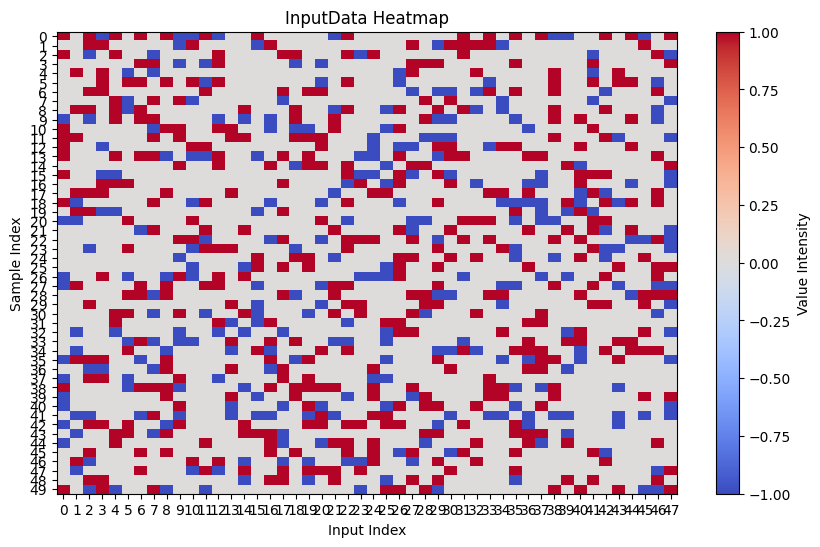

In [131]:
import matplotlib.pyplot as plt
import numpy as np

def plot_input_data(input_data: InputData):
    """Plots the InputData as a heatmap."""
    data_matrix = np.array([sample.data for sample in input_data.samples])  # Convert to 2D array
    
    plt.figure(figsize=(10, 6))
    plt.imshow(data_matrix, cmap="coolwarm", aspect="auto", interpolation="nearest")  # Heatmap

    # Labels and formatting
    plt.colorbar(label="Value Intensity")
    plt.xlabel("Input Index")
    plt.ylabel("Sample Index")
    plt.title("InputData Heatmap")
    plt.xticks(np.arange(data_matrix.shape[1]))
    plt.yticks(np.arange(data_matrix.shape[0]))

    plt.show()

# ✅ Generate and plot 10 samples of length 48
test_data = generate_random_data(50, 48, random_input_sample)
plot_input_data(test_data)


In [132]:
controller = Controller(48)
controller.synapses, controller.neurons

(BRAM_synaptic_weights(synapses=[SynapseForMemory(length=48, weights=[0 0 0 1 0 2 0 1 0 0 2 0 0 0 0 0 0 0 0 2 0 0 2 0 0 0 0 0 0 1 0 1 2 1 0 0 2
  2 1 0 0 0 1 0 1 3 0 0]), SynapseForMemory(length=48, weights=[1 2 0 1 0 0 0 2 0 1 1 1 0 1 1 0 2 1 0 0 0 0 1 1 0 2 2 1 2 1 0 0 0 1 0 2 1
  0 1 0 2 0 0 0 2 0 0 0]), SynapseForMemory(length=48, weights=[0 0 0 0 0 1 1 1 1 1 0 0 0 0 3 0 3 0 2 0 2 0 1 1 0 2 1 2 0 1 1 0 0 0 0 0 0
  0 1 0 2 0 0 0 0 0 0 2]), SynapseForMemory(length=48, weights=[0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0 2 0 1 2 0 0 0 1 0 0 1 0 0 0 0 2 0 3 0 0 0
  1 2 1 0 2 0 0 1 0 2 0]), SynapseForMemory(length=48, weights=[1 1 0 0 0 1 0 0 0 1 0 0 1 0 0 2 1 1 0 1 0 1 2 0 1 2 0 3 1 1 0 1 0 1 0 0 1
  1 2 1 0 1 0 2 1 1 1 2]), SynapseForMemory(length=48, weights=[0 0 1 1 0 0 0 0 0 0 0 3 1 1 0 0 1 0 0 1 0 1 1 1 0 0 2 2 1 0 0 1 0 0 0 0 0
  0 0 0 1 1 1 1 0 0 0 1]), SynapseForMemory(length=48, weights=[0 0 0 0 1 0 1 2 1 0 0 1 0 0 1 1 0 1 0 0 1 2 0 0 0 0 1 1 0 1 0 0 1 0 0 1 1
  0 1 1 2 0 2 0 1 1 0 1]), S